# Outline:

## We read the data and do some inspection
## We create a class to predict the TS/TO value
## Future Work


In [129]:
import io
import urllib.request  as urllib
import pandas as pd
import itertools
%matplotlib inline
from matplotlib import rcParams
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
rcParams['figure.figsize'] = 16,7

In [46]:
r = urllib.urlopen('https://drive.google.com/uc?authuser=0&id=18qenbF2j0S0UMj8nxfYqPjdvYYQ0lAZr&export=download')
df = pd.read_csv(io.BytesIO(r.read()), compression='zip', sep=',')

In [47]:
# convert the variables into appropriate data types
df['X1'] = df['X1'].astype(float)
df['X2'] = df['X2'].astype(float)
df['M'] = df['M'].astype(int)
df = df.fillna(0)

In [203]:
df.shape

(100000, 34)

In [48]:
df.head()

,X1,X2,X3,M,TS00,TO00,TS01,TO01,TS02,TO02,...,TS10,TO10,TS11,TO11,TS12,TO12,TS13,TO13,TS14,TO14
0,-1.25,-0.88,2,14,14:00,22:27,18:00,14:37,13:00,09:39,...,10:00,21:29,10:00,08:47,15:00,10:06,10:00,09:14,0,0
1,-0.14,-3.21,0,1,17:00,17:11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.23,0.08,3,1,19:00,09:22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.38,-1.30,3,2,12:00,12:38,08:00,09:04,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.50,0.22,2,6,14:00,21:59,11:00,17:01,15:00,23:47,...,0,0,0,0,0,0,0,0,0,0


### Before we go to modeling step, we need to check out if normalization/standardization is needed 
### As can be seen below, the data is already standardized and no need to do it. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x162570c18>,
      dtype=object)

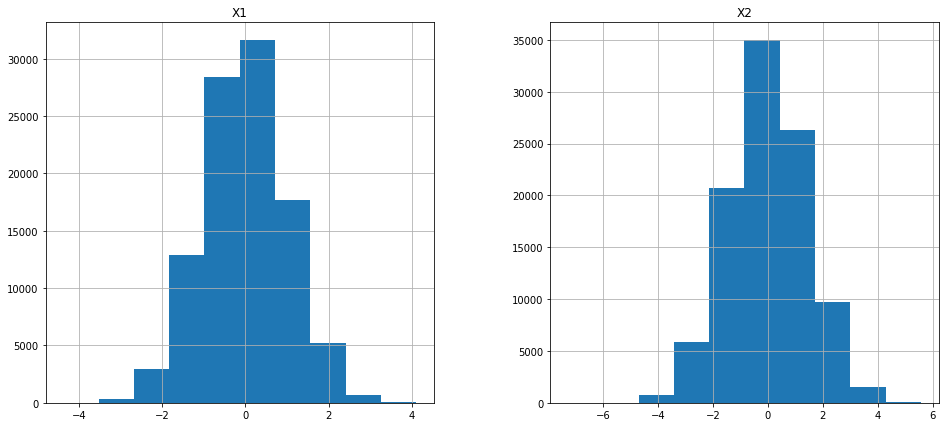

In [125]:
df[['X1', 'X2']].hist()

### Below we create a class that aims to predict TS/TO value
#### First we need to unpack the data as a user may have several TS/TO, so we need to have one TO/TS rogether with their variables
#### The class allow to train the models and plot the learning curve in order to check the overfitting.
#### Two models will be passed to the class: 
##### 1) SGDRegressor which is using SGD to find the best value that minimizes the TS-TO and we use also L2 regularization to reduce the overfitting problem
##### 2) DecisionTreeRegressor which is able to handel the non-linear data

# NOTE: we use TO as a target value instead TS as we wanna minimize TO and get as much as closer to it. So, the predicted TO will be considered as the TS in this case


In [199]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.model_selection import cross_val_score
import scikitplot as skplt


class EmailStatusPredictor():
    '''
    The following class preprocess the data, creates classfication model, and shows the testing results.
    '''
    def __init__(self, data, model):
        '''
        The regressor and its data are provided for the constructor.
        '''
        self.data = data
        self.model = model
        
    
    def preprocess_unpack(self):
        '''
        Unpack the data such that each row contains only one TS/TO for a user 
        '''
        dict = {}
        j = 0
        for index, row in self.data.iterrows():
            for i in range(0, row['M']):
                TS = 'TS' + str(i)
                TO = 'TO' + str(i)
                if(i < 10):
                    TS = 'TS0' + str(i)
                    TO = 'TO0' + str(i)
                TS = int(row[TS].replace(':', '').replace('-', ''))
                TO = int(row[TO].replace(':', '').replace('-', ''))

                if(TO < TS):
                    TO = TO + 2400

                dict[j] = {
                    'X1' : row['X1'],
                    'X2' : row['X2'],
                    'X3' : row['X3'],
                    'TS' : TS,
                    'TO' : TO
                }
                j = j + 1

        return pd.get_dummies(df.from_dict(dict, "index"), columns=['X3'], prefix = ['X3']) 
    
    def prepare_data_model(self, data):
        '''
        Get y, X
        '''
        y = data.TO
        X = data.drop(columns=['TS', 'TO'])
        
        return y, X

    def train_eval_model(self, y, X):
        '''
        Train and test the model
        ''' 
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict(X_test)
        print('The RMSE for the train/test split data: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    
    def train_cross_val_model(self, y, X):
        '''
        Validate the model using cross validation method and compute the average value of RMSEs
        '''
        scores = cross_val_score(self.model, X, y, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)
        print('The avergare of RMSEs for the cross validation: ', np.mean(rmse_scores))

        
    def plot_cv_training_learning_curve(self, y, X):
        '''
        Plot the learning curve to check the variance of learning on the training and cv data
        '''    
        skplt.estimators.plot_learning_curve(self.model, X, y, cv = 5, scoring='neg_mean_squared_error')
        plt.show()
   
        
    def pipline(self):
        '''
        Pipline that runs the needed functions to train and evalaute the regression models
        '''
        data = self.preprocess_unpack()
        y, X = self.prepare_data_model(data)
        
        self.train_eval_model(y, X)
        self.train_cross_val_model(y, X)
        self.plot_cv_training_learning_curve(y, X)
        

Below we build a SGDRegressor to predict the TO. Note that the RMSE value is high whicu may require further optmizations in future

We also plot the learning curve between the training and cv data. Note that the value are sequared and thats why you see the high values

As can be seen below that the variance after 200000 training data points gets lower for the Training and Cross Validation outputs. That also implies there is a good chance that there is no overfitting

The RMSE for the train/test split data:  888.8740222652107
The avergare of RMSE for the cross validation:  887.6615750287932


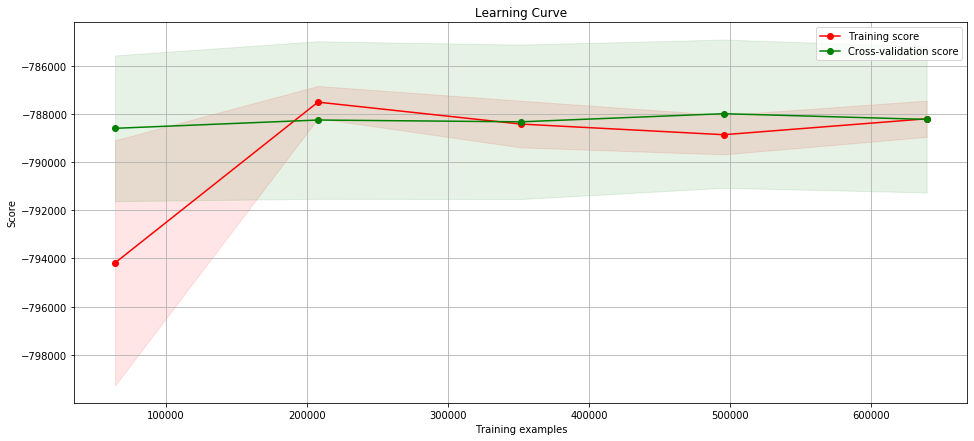

In [196]:
emailStatusPredictor = EmailStatusPredictor(df, linear_model.SGDRegressor(max_iter=1000, tol=1e-3))
emailStatusPredictor.pipline()

Here we try DecisionTreeRegressor to see if it can give better results and it does as can be seen. That means that the model was able capture some of non-linear data points

As can be seen below that the variance after 350000 training data points gets lower for the Training and Cross Validation outputs. That also implies there is a good chance that there is no overfitting

The RMSE for the train/test split data:  834.8747776729331
The avergare of RMSE for the cross validation:  834.0601527068493


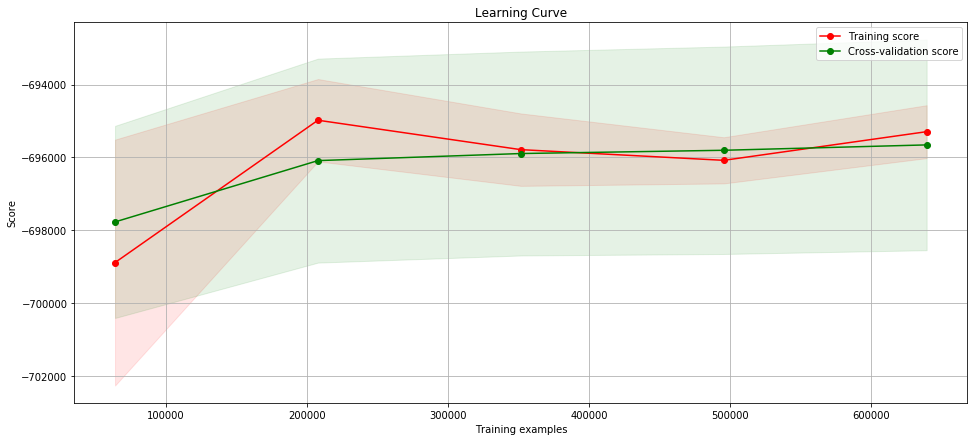

In [200]:
emailStatusPredictor = EmailStatusPredictor(df, DecisionTreeRegressor(max_depth=5))
emailStatusPredictor.pipline()

## Future Work:
### Clearly RMSE value is high which means some optimization might be required. For example, we may need to have a loss function such that TS <= TO_predicted <= TO. For instance constained linear regression can be used: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html#scipy.optimize.lsq_linear